 # predict-online-gaming-behaviour

In [1]:
!pip install kagglehub matplotlib pandas scikit-learn shap

In [65]:
import dice_ml
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import shap
from alibi.explainers import ALE, plot_ale
from IPython.display import display
from kagglehub import KaggleDatasetAdapter
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

In [3]:
shap.initjs()

 ## Paso 1: análisis del dataset

 ### Describir el problema a resolver

 Clasificación (multiclass)

 ### Analizar el dataset

In [4]:
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "rabieelkharoua/predict-online-gaming-behavior-dataset",
    "online_gaming_behavior_dataset.csv",
)
df.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


 #### Describir los atributos del dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

 #### Describir relación entre los atributos

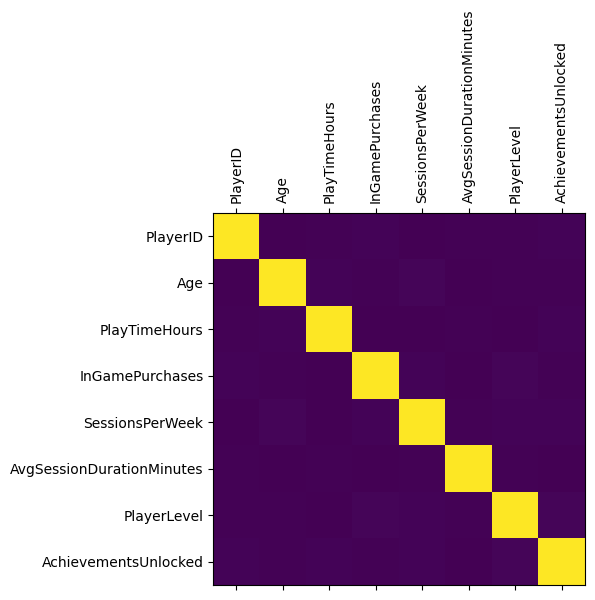

In [6]:
corr = df.corr(numeric_only=True)
plt.matshow(corr)
plt.xticks(ticks=range(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=range(len(corr.index)), labels=corr.index)
plt.show()

 ## Paso 2: preparar el dataset

 * Eliminar valores nulos, atributos no necesarios

 * Convertir atributos categóricos en numéricos

 * Normalización o estandarización

In [7]:
X_transformer = ColumnTransformer(
    [
        (
            "standardscaler",
            StandardScaler(),
            [
                "Age",
                "PlayTimeHours",
                "SessionsPerWeek",
                "AvgSessionDurationMinutes",
                "PlayerLevel",
                "AchievementsUnlocked",
            ],
        ),
        (
            "onehotencoder",
            OneHotEncoder(),
            [
                "Gender",
                "Location",
                "GameGenre",
                "GameDifficulty",
            ],
        ),
        (
            "passthrough",
            "passthrough",
            [
                "InGamePurchases",
            ],
        ),
    ],
    remainder="drop",
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [8]:
y_transformer = LabelEncoder()

In [9]:
X = df.drop(columns=["EngagementLevel"])
y = y_transformer.fit_transform(df["EngagementLevel"])

 ## Paso 3: aplicar y evaluar modelos de IA

 ### Decidir qué modelos de IA aplicar

In [10]:
classifiers = {
    AdaBoostClassifier(): {
        "classifier__n_estimators": [50, 100],
        "classifier__learning_rate": [1.0, 0.5],
    },
    BaggingClassifier(): {
        "classifier__n_estimators": [10, 20],
        "classifier__max_samples": [0.5, 1.0],
        "classifier__max_features": [0.5, 1.0],
    },
    DecisionTreeClassifier(): {
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 3],
        "classifier__min_samples_leaf": [1, 2],
    },
    HistGradientBoostingClassifier(): {
        "classifier__max_iter": [100, 200],
        "classifier__learning_rate": [0.1, 0.01],
        "classifier__max_depth": [None, 3],
        "classifier__l2_regularization": [0.0, 0.1],
    },
    KNeighborsClassifier(): {
        "classifier__n_neighbors": [3, 5],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2],
        "classifier__leaf_size": [20, 30],
    },
    LogisticRegression(): {
        "classifier__C": [1.0, 0.1],
        "classifier__max_iter": [100, 200],
        "classifier__tol": [1e-3, 1e-4],
    },
    MLPClassifier(): {
        "classifier__hidden_layer_sizes": [(100,), (50, 50)],
        "classifier__max_iter": [1000],
    },
    Perceptron(): {
        "classifier__penalty": [None, "l2"],
        "classifier__alpha": [0.0001, 0.001],
        "classifier__fit_intercept": [True, False],
        "classifier__max_iter": [1000, 2000],
        "classifier__tol": [1e-3, 1e-4],
        "classifier__eta0": [1.0, 0.1],
    },
    RandomForestClassifier(): {
        "classifier__n_estimators": [100, 200],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 3],
        "classifier__min_samples_leaf": [1, 2],
    },
}

 ### Decidir qué tipo de evaluación se va a realizar

In [11]:
estimator_type = GridSearchCV

 ### Decidir los posibles tamaños del conjunto de entrenamiento y de evaluación

In [12]:
test_size = 0.25

 ### Decidir qué métricas de evaluación se van a usar

In [13]:
scoring = "accuracy"

 ### Aplicar los modelos y la evaluación

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [15]:
estimators = []
for classifier, param_grid in classifiers.items():
    best_model = Pipeline([("transformer", X_transformer), ("classifier", classifier)])
    estimator = estimator_type(best_model, param_grid, scoring=scoring, n_jobs=-1)
    estimator.fit(X_train, y_train)
    estimators.append(estimator)
    cv_results = pd.DataFrame(estimator.cv_results_)
    cv_results = cv_results.sort_values("rank_test_score")
    cv_results.columns.name = classifier.__class__.__name__
    display(cv_results.head())

AdaBoostClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,5.213022,0.421087,0.087601,0.016134,0.5,100,"{'classifier__learning_rate': 0.5, 'classifier...",0.798168,0.815654,0.798168,0.806162,0.802331,0.804097,0.006500,1
1,7.322045,1.100346,0.390192,0.145386,1.0,100,"{'classifier__learning_rate': 1.0, 'classifier...",0.792007,0.806994,0.783181,0.811490,0.823647,0.803464,0.014331,2
2,4.789642,0.765581,0.238610,0.044973,0.5,50,"{'classifier__learning_rate': 0.5, 'classifier...",0.799833,0.785012,0.790841,0.803164,0.808993,0.797569,0.008601,3
0,3.261441,0.516756,0.211369,0.088274,1.0,50,"{'classifier__learning_rate': 1.0, 'classifier...",0.760366,0.806661,0.769192,0.818818,0.819650,0.794938,0.025205,4


BaggingClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_features,param_classifier__max_samples,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.295158,0.330203,0.115611,0.045444,1.0,0.5,20,"{'classifier__max_features': 1.0, 'classifier_...",0.916403,0.913239,0.915237,0.906911,0.911074,0.912573,0.003362,1
7,3.400757,0.294633,0.048624,0.007345,1.0,1.0,20,"{'classifier__max_features': 1.0, 'classifier_...",0.911407,0.913405,0.916736,0.905912,0.911574,0.911807,0.003516,2
4,1.563103,0.120114,0.101862,0.021107,1.0,0.5,10,"{'classifier__max_features': 1.0, 'classifier_...",0.909575,0.911907,0.909908,0.903913,0.907577,0.908576,0.002706,3
6,3.009806,0.142730,0.062448,0.010284,1.0,1.0,10,"{'classifier__max_features': 1.0, 'classifier_...",0.909076,0.909742,0.910075,0.901415,0.906411,0.907344,0.003232,4
0,0.996152,0.169656,0.119553,0.034053,0.5,0.5,10,"{'classifier__max_features': 0.5, 'classifier_...",0.794005,0.726728,0.711740,0.750874,0.793672,0.755404,0.033775,5


DecisionTreeClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.530100,0.060688,0.055862,0.015586,entropy,None,1,"{'classifier__criterion': 'entropy', 'classifi...",0.835304,0.837635,0.841632,0.833639,0.839301,0.837502,0.002831,1
5,0.484671,0.034250,0.045172,0.002669,entropy,None,2,"{'classifier__criterion': 'entropy', 'classifi...",0.824813,0.832806,0.839967,0.832973,0.835470,0.833206,0.004929,2
1,0.495661,0.076601,0.068784,0.006483,gini,None,2,"{'classifier__criterion': 'gini', 'classifier_...",0.835470,0.829642,0.834804,0.829975,0.835637,0.833106,0.002709,3
0,0.485365,0.081511,0.049997,0.012367,gini,None,1,"{'classifier__criterion': 'gini', 'classifier_...",0.831474,0.826311,0.831307,0.827644,0.835137,0.830375,0.003122,4
6,0.219442,0.031733,0.053486,0.030811,entropy,3,1,"{'classifier__criterion': 'entropy', 'classifi...",0.802165,0.814654,0.799833,0.793672,0.801665,0.802398,0.006834,5


HistGradientBoostingClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.622438,0.288507,0.242208,0.047062,0.0,0.10,None,200,"{'classifier__l2_regularization': 0.0, 'classi...",0.915903,0.917902,0.922065,0.909409,0.913239,0.915704,0.004267,1
8,2.686466,0.349050,0.290615,0.051364,0.1,0.10,None,100,"{'classifier__l2_regularization': 0.1, 'classi...",0.917735,0.919067,0.920566,0.908077,0.912739,0.915637,0.004605,2
0,2.305423,0.137623,0.234687,0.013622,0.0,0.10,None,100,"{'classifier__l2_regularization': 0.0, 'classi...",0.917236,0.917569,0.921232,0.907577,0.913572,0.915437,0.004618,3
9,2.340611,0.151864,0.251915,0.053638,0.1,0.10,None,200,"{'classifier__l2_regularization': 0.1, 'classi...",0.914238,0.916736,0.920566,0.909076,0.913072,0.914738,0.003822,4
13,9.426497,0.874365,0.651930,0.207982,0.1,0.01,None,200,"{'classifier__l2_regularization': 0.1, 'classi...",0.914738,0.914571,0.918401,0.906911,0.911907,0.913306,0.003807,5


KNeighborsClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__leaf_size,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.110655,0.021025,1.625520,0.191313,20,5,2,distance,"{'classifier__leaf_size': 20, 'classifier__n_n...",0.752706,0.751707,0.756203,0.742048,0.742714,0.749076,0.005670,1
15,0.122630,0.028695,1.652713,0.248660,30,5,2,distance,"{'classifier__leaf_size': 30, 'classifier__n_n...",0.752706,0.751707,0.756203,0.742048,0.742714,0.749076,0.005670,1
6,0.139384,0.017259,1.611635,0.126140,20,5,2,uniform,"{'classifier__leaf_size': 20, 'classifier__n_n...",0.749042,0.746711,0.754371,0.735387,0.742048,0.745512,0.006433,3
14,0.123849,0.025862,2.098102,0.261233,30,5,2,uniform,"{'classifier__leaf_size': 30, 'classifier__n_n...",0.749042,0.746711,0.754371,0.735387,0.742048,0.745512,0.006433,3
5,0.105516,0.014971,7.314467,0.824188,20,5,1,distance,"{'classifier__leaf_size': 20, 'classifier__n_n...",0.739384,0.741216,0.746045,0.741049,0.737552,0.741049,0.002828,5


LogisticRegression,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.201670,0.018604,0.047322,0.020701,1.0,100,0.0010,"{'classifier__C': 1.0, 'classifier__max_iter':...",0.819817,0.830974,0.824313,0.819317,0.820316,0.822948,0.004386,1
1,0.353713,0.086490,0.040801,0.020866,1.0,100,0.0001,"{'classifier__C': 1.0, 'classifier__max_iter':...",0.819484,0.830641,0.824646,0.819484,0.820483,0.822948,0.004293,1
2,0.212264,0.021230,0.054751,0.014536,1.0,200,0.0010,"{'classifier__C': 1.0, 'classifier__max_iter':...",0.819817,0.830974,0.824313,0.819317,0.820316,0.822948,0.004386,1
3,0.289937,0.068644,0.058051,0.018240,1.0,200,0.0001,"{'classifier__C': 1.0, 'classifier__max_iter':...",0.819484,0.830641,0.824646,0.819484,0.820483,0.822948,0.004293,1
4,0.214016,0.042945,0.079434,0.010203,0.1,100,0.0010,"{'classifier__C': 0.1, 'classifier__max_iter':...",0.819983,0.830641,0.824147,0.819484,0.820316,0.822914,0.004203,5


MLPClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__hidden_layer_sizes,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,67.997472,5.996562,0.042236,0.016846,"(50, 50)",1000,"{'classifier__hidden_layer_sizes': (50, 50), '...",0.904746,0.909242,0.915404,0.900583,0.915404,0.909076,0.005848,1
0,65.308256,7.603680,0.035994,0.018655,"(100,)",1000,"{'classifier__hidden_layer_sizes': (100,), 'cl...",0.901249,0.907910,0.899584,0.898085,0.900083,0.901382,0.003418,2


Perceptron,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__eta0,param_classifier__fit_intercept,param_classifier__max_iter,param_classifier__penalty,param_classifier__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,0.471313,0.163850,0.065307,0.021573,0.0001,0.1,False,2000,l2,0.0001,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.707910,0.643297,0.653789,0.590841,0.676103,0.654388,0.038724,1
27,0.410154,0.053500,0.073012,0.021328,0.0001,0.1,False,1000,l2,0.0001,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.707910,0.643297,0.653789,0.590841,0.676103,0.654388,0.038724,1
50,0.351799,0.038994,0.051582,0.010917,0.0010,0.1,True,1000,l2,0.0010,"{'classifier__alpha': 0.001, 'classifier__eta0...",0.676103,0.611990,0.630475,0.621649,0.668110,0.641665,0.025659,3
54,0.311914,0.022330,0.048248,0.009653,0.0010,0.1,True,2000,l2,0.0010,"{'classifier__alpha': 0.001, 'classifier__eta0...",0.676103,0.611990,0.630475,0.621649,0.668110,0.641665,0.025659,3
30,0.500687,0.145861,0.087766,0.041280,0.0001,0.1,False,2000,l2,0.0010,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.707910,0.643297,0.584846,0.629475,0.625978,0.638301,0.039894,5


RandomForestClassifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,17.053371,1.539010,0.606673,0.159191,entropy,None,1,200,"{'classifier__criterion': 'entropy', 'classifi...",0.899251,0.905579,0.904246,0.898918,0.900583,0.901715,0.002702,1
11,16.955342,1.397725,0.419842,0.125100,entropy,None,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.899750,0.901415,0.906411,0.896420,0.902248,0.901249,0.003263,2
8,8.077419,0.708579,0.305719,0.026962,entropy,None,1,100,"{'classifier__criterion': 'entropy', 'classifi...",0.900250,0.902082,0.907910,0.894754,0.898085,0.900616,0.004387,3
10,8.036665,0.812745,0.383203,0.087070,entropy,None,2,100,"{'classifier__criterion': 'entropy', 'classifi...",0.899251,0.903247,0.902082,0.896753,0.897752,0.899817,0.002485,4
1,15.496882,1.281171,0.581807,0.247652,gini,None,1,200,"{'classifier__criterion': 'gini', 'classifier_...",0.897752,0.897918,0.903414,0.892590,0.892756,0.896886,0.003999,5


 #### Tomar una decisión de qué modelo (con su configuración) es la mejor

In [16]:
best_estimator = max(estimators, key=lambda model: model.best_score_)
best_model = best_estimator.best_estimator_
best_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'PlayTimeHours',
                                                   'SessionsPerWeek',
                                                   'AvgSessionDurationMinutes',
                                                   'PlayerLevel',
                                                   'AchievementsUnlocked']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Location',
                                                   'GameGenre',
                                                   'GameDifficulty']),
                                                 ('passthrough', 'passthrough',
                                                  ['InGamePurchases'])],
                                   verbose_feature_names_out=False)),
                ('classifier', HistGradientBoostingClassifier(max_iter=200))])

In [17]:
y_pred = best_model.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred, target_names=y_transformer.classes_))

              precision    recall  f1-score   support

        High       0.92      0.88      0.90      2620
         Low       0.91      0.89      0.90      2560
      Medium       0.91      0.95      0.93      4829

    accuracy                           0.91     10009
   macro avg       0.92      0.91      0.91     10009
weighted avg       0.91      0.91      0.91     10009



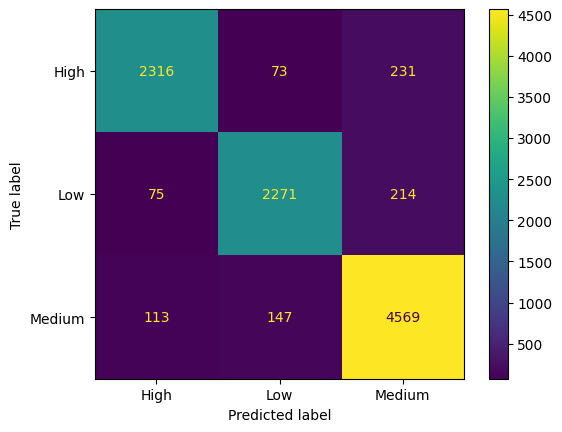

In [19]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=y_transformer.classes_,
)
plt.show()

 ## Paso 4: aplicar XAI

 ### Decidir qué técnicas XAI aplicar

 * SHAP
 * ALE
 * DiCE

 ### Aplicar las técnicas XAI y describir las explicaciones obtenidas

In [27]:
transformer = best_model.named_steps["transformer"]
classifier = best_model.named_steps["classifier"]

In [41]:
x_train = transformer.transform(resample(X_train, n_samples=10))
x_test = transformer.transform(resample(X_test, n_samples=10))

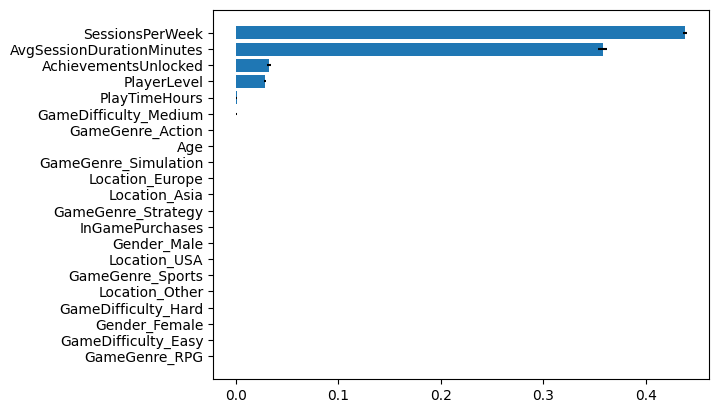

In [42]:
importances = permutation_importance(
    classifier, transformer.transform(X_test), y_test, scoring=scoring
)
idx = importances.importances_mean.argsort()
plt.barh(
    transformer.get_feature_names_out()[idx],
    importances.importances_mean[idx],
    xerr=importances.importances_std[idx],
)
plt.show()

In [76]:
explainer = shap.KernelExplainer(
    classifier.predict_proba,
    x_train,
    link="logit",
    n_jobs=-1,
)
explanation = explainer(x_test)
shap_values = explainer.shap_values(x_test)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

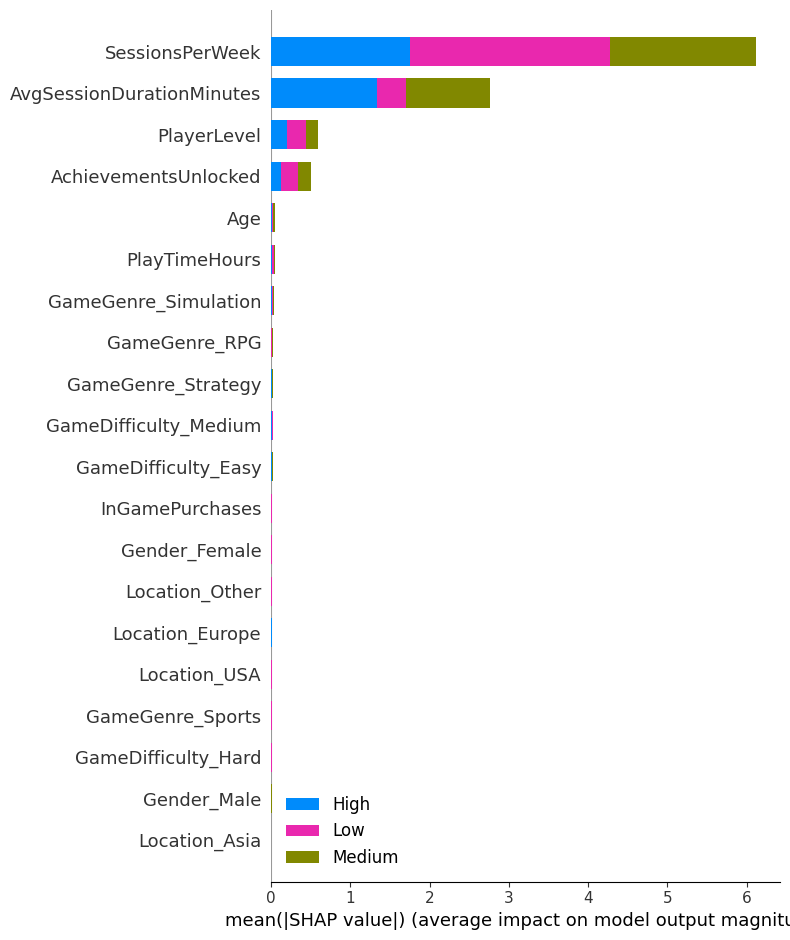

In [ ]:
shap.summary_plot(
    shap_values,
    x_test,
    feature_names=transformer.get_feature_names_out(),
    class_names=y_transformer.classes_,
)

In [ ]:
shap.plots.force(
    explainer.expected_value[0],
    shap_values[0],
    feature_names=transformer.get_feature_names_out(),
)

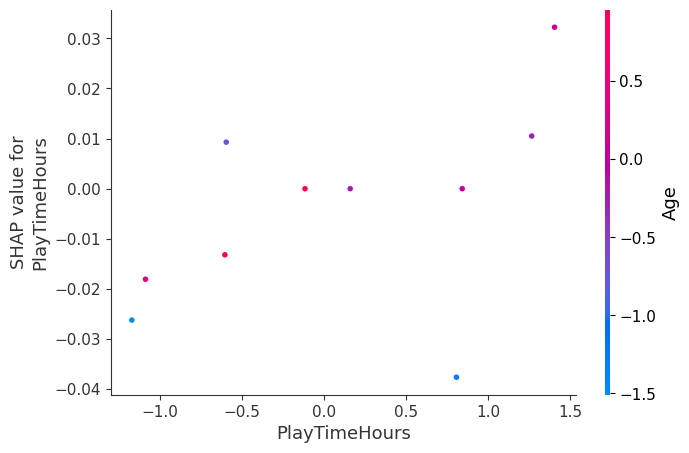

In [ ]:
shap.dependence_plot(
    "PlayTimeHours",
    shap_values[0],
    x_test,
    feature_names=transformer.get_feature_names_out(),
)

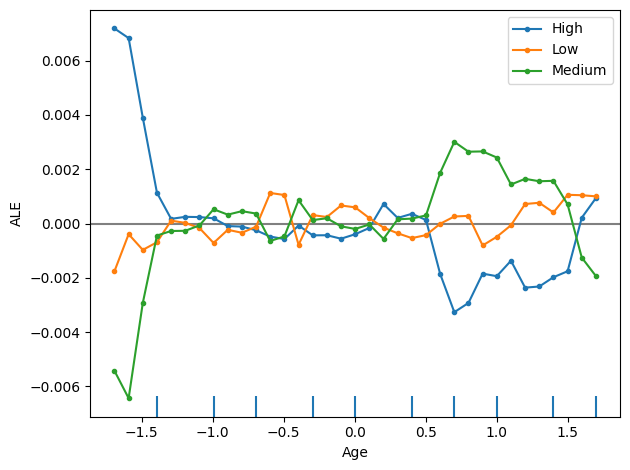

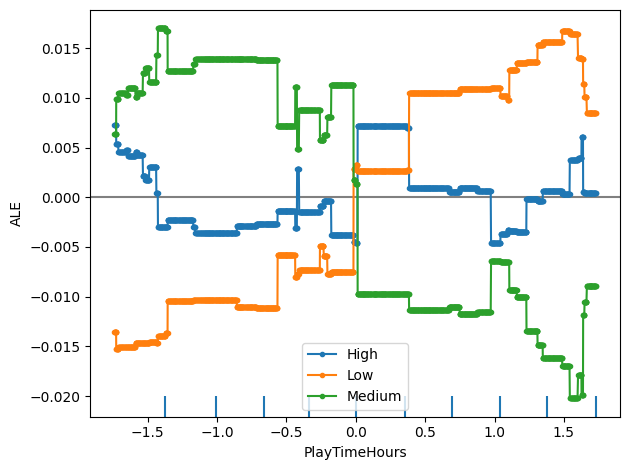

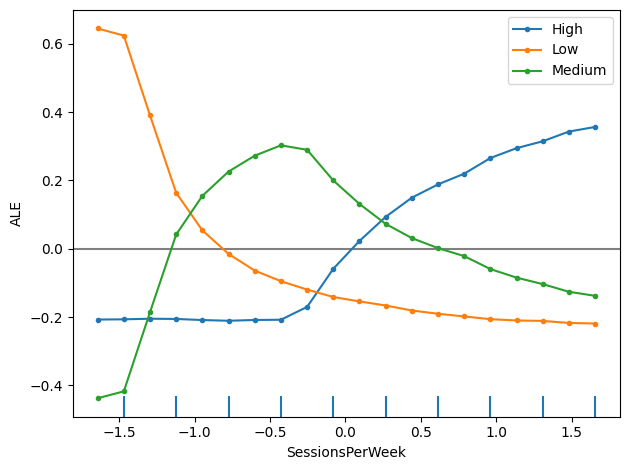

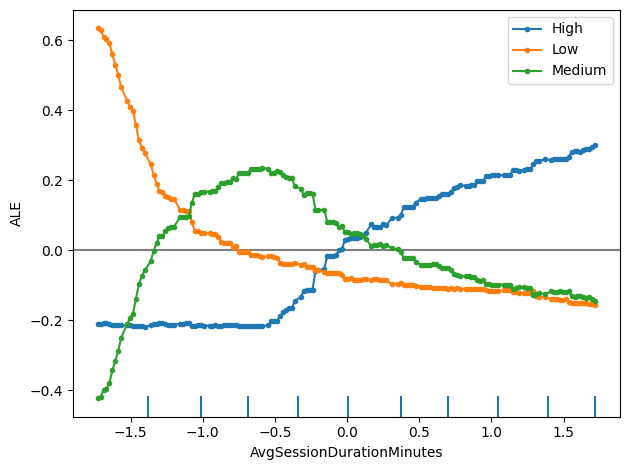

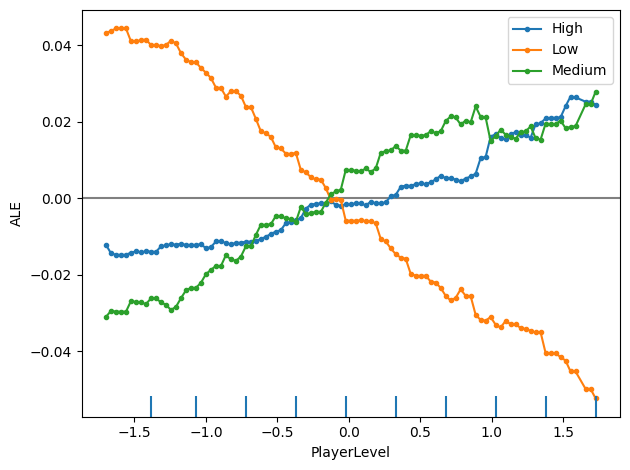

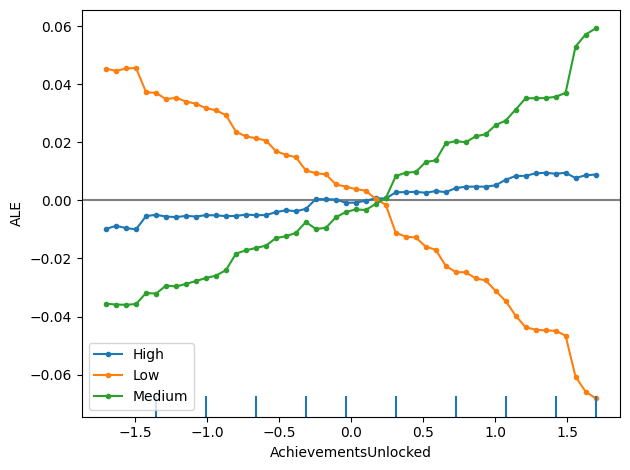

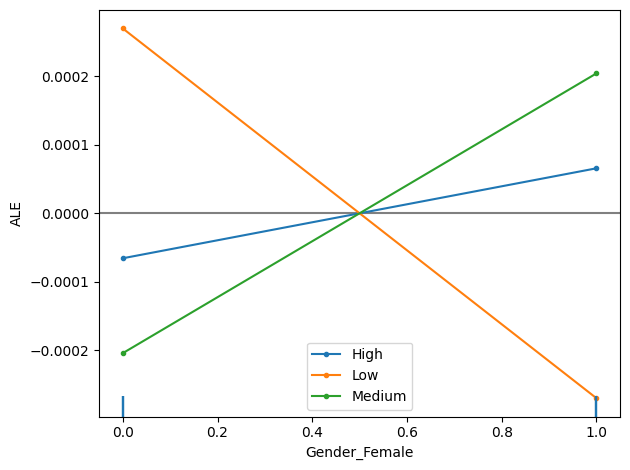

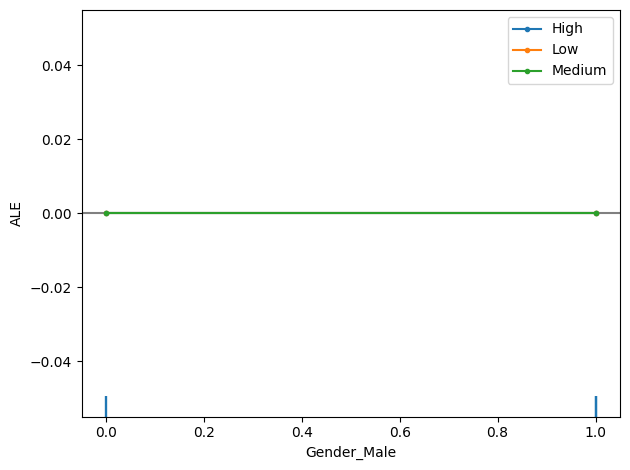

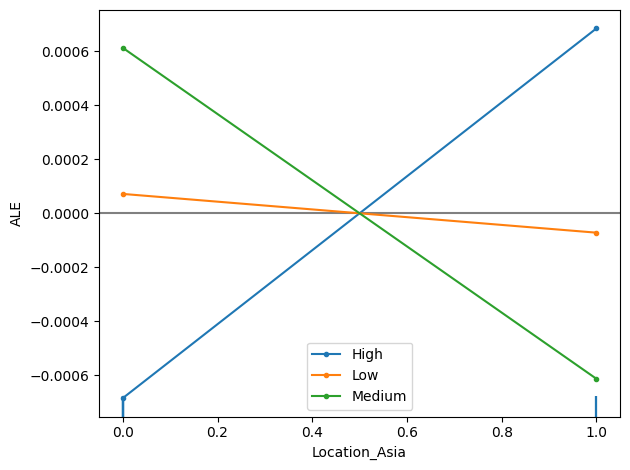

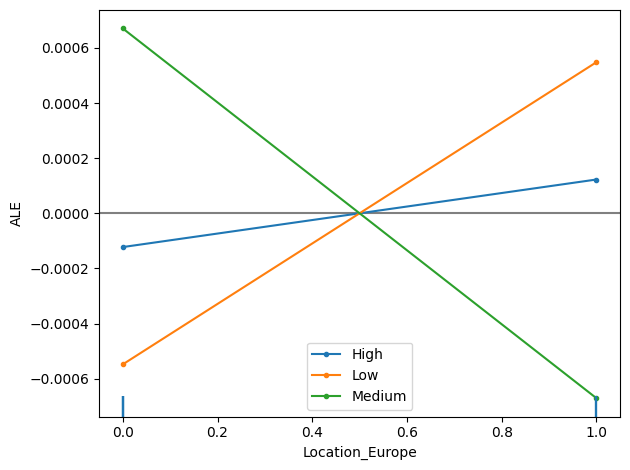

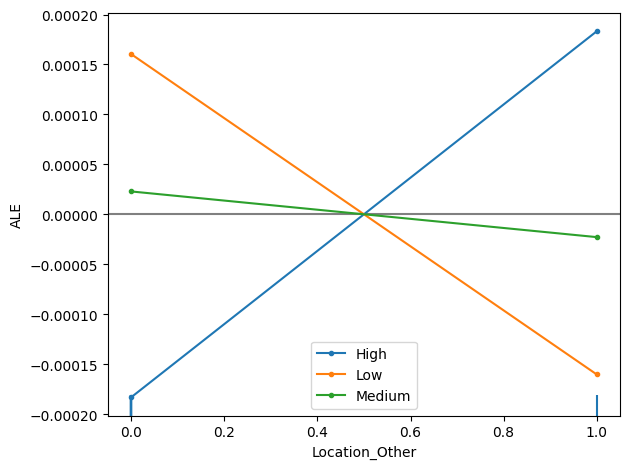

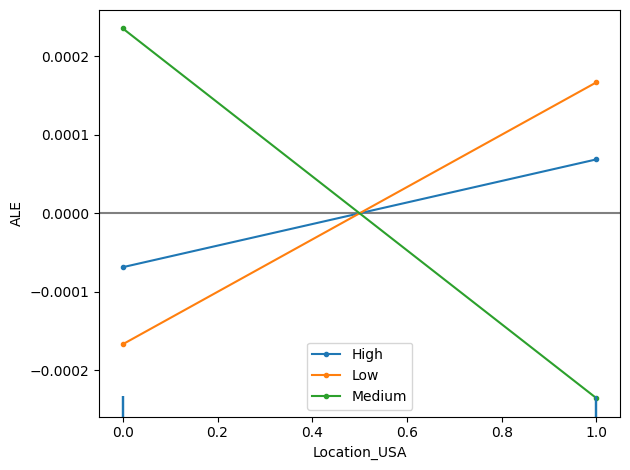

In [64]:
ale = ALE(
    classifier.predict_proba,
    feature_names=transformer.get_feature_names_out(),
    target_names=y_transformer.classes_,
)
for feature in range(len(X_test.columns)):
    exp = ale.explain(transformer.transform(X_test), features=[feature])
    plot_ale(exp)

In [ ]:
d = dice_ml.Data(
    dataframe=df,
    continuous_features=[
        "Age",
        "PlayTimeHours",
        "SessionsPerWeek",
        "AvgSessionDurationMinutes",
        "PlayerLevel",
        "AchievementsUnlocked",
    ],
    outcome_name="EngagementLevel",
)
m = dice_ml.Model(model=best_model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

In [67]:
e1 = exp.generate_counterfactuals(X_test[0:1], total_CFs=2, desired_class=0)
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 0)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,14,136,8,45,0
1,25838,46,Female,Asia,Action,4.86569,0,Easy,13,136,8,45,0


In [68]:
e1 = exp.generate_counterfactuals(X_test[0:1], total_CFs=2, desired_class=1)
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 1)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,48,8,28,1
1,25838,46,Male,Asia,Action,4.86569,0,Hard,4,65,8,45,1


In [69]:
e1 = exp.generate_counterfactuals(X_test[0:1], total_CFs=2, desired_class=2)
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2
1,48127,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2


In [75]:
e2 = exp.generate_counterfactuals(
    X_test[0:1],
    total_CFs=2,
    desired_class=0,
    features_to_vary=["Age", "PlayTimeHours", "SessionsPerWeek"],
)
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 0)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,-,-,-,-,-,-,-,-,17,-,-,-,0
1,-,-,-,-,-,3.3582853,-,-,19,-,-,-,0


In [74]:
e2 = exp.generate_counterfactuals(
    X_test[0:1],
    total_CFs=2,
    desired_class=1,
    features_to_vary=["Age", "PlayTimeHours", "SessionsPerWeek"],
)
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 1)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,-,-,-,-,-,-,-,-,1,-,-,-,1
1,-,24,-,-,-,-,-,-,1,-,-,-,1


In [73]:
e2 = exp.generate_counterfactuals(
    X_test[0:1],
    total_CFs=2,
    desired_class=2,
    features_to_vary=["Age", "PlayTimeHours", "SessionsPerWeek"],
)
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:03<00:00,  3.69s/it]

Query instance (original outcome : 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,25838,46,Male,Asia,Action,4.86569,0,Easy,4,136,8,45,2



Diverse Counterfactual set (new outcome: 2)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,-,-,-,-,-,10.5375521,-,-,-,-,-,-,-
1,-,-,-,-,-,10.9888814,-,-,-,-,-,-,-
